# Proposal
By Marcellinus Jerricho, Edward Jeremy Lo, Rana Harris Farooq

## Content
This proposal contains the following:
1. [Data](#Data)
2. [Research Questions](#Research-Questions)
3. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
4. [Timeline](#Timeline)
5. [Teamwork](#Teamwork)

In [1]:
# importing necessary modules
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
np.random.seed(42)
plt.style.use('fivethirtyeight')
%matplotlib inline

## Data

### Penalties

The [first dataset](https://www.kaggle.com/emilerichard/penalty-statistics-20192020) is about football penalty kicks from the 2019-2020 season from Bundesliga, Serie A, Ligue 1, English Premier League, and the European Champions League. The dataset contains:
1. Name of the league of the match
2. Date of the match
3. The names of home and away team
4. The name of the team taking the penalty
5. The name of the player taking the penalty
6. The minute of the game the penalty happened
7. A description on whether the penalty changes the result
8. A description on whether the penalty became a goal
9. A description on whether the penalty taker is a substitute
10. The penalty taker’s position
11. A description on whether the team that got the penalty won the match
12. Whether the penalty became the last goal of the match. 
We found the data set from Kaggle; it has 494 observations. This dataset has 3 predictors: the time penalty is taken, home/away status, and player position. 

In [2]:
# initial raw data
# PT = Penalty Taker
columns_to_drop = ['Pen taker', 'Journee', 'Date', 
                   'LtD game-changing pen', 'DtW game-changing pen', 
                   'L no game-changing', 'W no game-changing', 'PT sub', 'Last Goal']
penalty_stats = pd.read_csv('penalty_stats_19_20.csv').drop(columns=columns_to_drop).dropna()
penalty_stats.head()

,Id,Competition,Home team,Away team,Team taking pen,Minute,Scored,PT position,Team win
0,1,Premier League,West Ham,Manchester City,Away,84.0,NO,ST,YES
1,2,Premier League,West Ham,Manchester City,Away,86.0,YES,ST,YES
2,3,Premier League,Manchester United,Chelsea,Home,18.0,YES,W,YES
3,4,Premier League,Aston Villa,Bournemouth,Away,2.0,YES,OM,YES
4,5,Premier League,Wolverhampton,Manchester United,Away,68.0,NO,DM,NO


In [3]:
# get the dummies
columns_to_get_dummies = ['Team taking pen', 'Scored', 'Team win']
penalty_stats_dummies = pd.get_dummies(penalty_stats[columns_to_get_dummies], drop_first=True)

In [4]:
# combining penalty
columns_to_join = ['Competition', 'Home team', 'Away team', 'Minute', 'PT position']
penalty = penalty_stats[columns_to_join].join(penalty_stats_dummies)
penalty.head()

,Competition,Home team,Away team,Minute,PT position,Team taking pen_Home,Scored_YES,Team win_YES
0,Premier League,West Ham,Manchester City,84.0,ST,0,0,1
1,Premier League,West Ham,Manchester City,86.0,ST,0,1,1
2,Premier League,Manchester United,Chelsea,18.0,W,1,1,1
3,Premier League,Aston Villa,Bournemouth,2.0,OM,0,1,1
4,Premier League,Wolverhampton,Manchester United,68.0,DM,0,0,0


In [5]:
# getting the team taking penalty
def get_PT_team(row):
    if row['Team taking pen_Home']:
        return row['Home team']
    return row['Away team']

penalty['PT team'] = penalty.apply(get_PT_team, axis=1)
penalty.head()

,Competition,Home team,Away team,Minute,PT position,Team taking pen_Home,Scored_YES,Team win_YES,PT team
0,Premier League,West Ham,Manchester City,84.0,ST,0,0,1,Manchester City
1,Premier League,West Ham,Manchester City,86.0,ST,0,1,1,Manchester City
2,Premier League,Manchester United,Chelsea,18.0,W,1,1,1,Manchester United
3,Premier League,Aston Villa,Bournemouth,2.0,OM,0,1,1,Bournemouth
4,Premier League,Wolverhampton,Manchester United,68.0,DM,0,0,0,Manchester United


### Payrolls

The [second dataset](https://www.capology.com) is about the payroll of each club: the total amount of salary each club paid in that year, in Euros. We found the dataset from Capology. It contains 80 rows. This dataset has 1 predictor: the payroll of each club. 

In [6]:
# getting individual datasets
bundesliga = pd.read_csv('bundesliga.csv')[['Club', 'Annual Gross (IN EUR']]
ligue1 = pd.read_csv('ligue-1.csv')[['Club', 'Annual Gross (IN EUR']]
serieA = pd.read_csv('serieA.csv')[['Club', 'Annual Gross (IN EUR']]
laliga = pd.read_csv('la-liga.csv')[['Club', 'Annual Gross (IN EUR']]
primeiraliga = pd.read_csv('primeira-liga.csv')[['Club', 'Annual Gross (IN EUR']]
# NOTE: epl is in GBP, not in EUR
epl = pd.read_csv('epl.csv')[['Club', 'Annual Gross (IN GBP']]\
        .rename(columns={'Annual Gross (IN GBP': 'Payroll'}).drop_duplicates('Club')

In [7]:
# defining functions to convert the currency to float
def get_payroll_float(payroll_str):
    '''
    Convert the payroll in string into payroll in integers.
    '''
    payroll_int = float("".join(re.findall('\d+', payroll_str)))
    return payroll_int * 1000

def convert_GBP_to_EUR(payroll_gbp):
    '''
    Convert the payroll from GBP currency to EUR currency for EPL
    Source: https://www.exchangerates.org.uk/GBP-EUR-spot-exchange-rates-history-2019.html#:~:text=Average%20exchange%20rate%20in%202019%3A%201.1405%20EUR.
    '''
    return payroll_gbp * 1.1405

In [8]:
# Combining the payroll datasets
payroll_EUR = bundesliga.append(ligue1).append(serieA).append(laliga).append(primeiraliga).reset_index()\
                        .rename(columns={'Annual Gross (IN EUR': 'Payroll'}).drop_duplicates('Club')
payroll_EUR['Payroll_EUR'] = payroll_EUR['Payroll'].apply(get_payroll_float)
payroll_epl = epl
payroll_epl['Payroll_EUR'] = payroll_epl['Payroll'].apply(get_payroll_float).apply(convert_GBP_to_EUR)
payroll = payroll_EUR.append(payroll_epl).reset_index().drop(columns=['Payroll', 'index', 'level_0'])
payroll.head()

,Club,Payroll_EUR
0,Paderborn,7.010000e+08
1,Wolfsburg,6.687000e+09
2,Eintracht Frankfurt,4.307000e+09
3,Dusseldorf,2.195000e+09
4,Schalke 04,4.863000e+09


### Stadium Capacity

The [third dataset](https://data.world/johayes13/football-soccer-stadiums) is about the stadium capacity of each match: it has the total number of seats in each stadium. The dataset has 2024 observations. We obtained it from data.world. This dataset has 1 predictor: the stadium’s number of seats. 

In [9]:
capacity = pd.read_csv('football-stadiums.csv')[['Confederation', 'HomeTeams', 'Capacity']]
capacity = capacity.drop(columns=['Confederation']).rename(columns={'Capacity': 'Stadium cap'})
capacity.head()

,HomeTeams,Stadium cap
0,Besëlidhja,7000
1,Flamurtari Vlorë,8200
2,KF Laçi,5000
3,Teuta,12040
4,"KF Tirana, Dinamo, Partizani",9500


### Combining all datasets

In [10]:
penalty_payroll = penalty.join(payroll.set_index('Club'), on='PT team')
data = penalty_payroll.join(capacity.set_index('HomeTeams'), on='Home team')
data.head()
# CHECKING for NaN
# penalty_payroll[penalty_payroll['Payroll_EUR'].isnull()]
# data[data['Stadium cap'].isnull()]

,Competition,Home team,Away team,Minute,PT position,Team taking pen_Home,Scored_YES,Team win_YES,PT team,Payroll_EUR,Stadium cap
0,Premier League,West Ham,Manchester City,84.0,ST,0,0,1,Manchester City,1.699231e+10,35345.0
0,Premier League,West Ham,Manchester City,84.0,ST,0,0,1,Manchester City,1.699231e+10,60000.0
1,Premier League,West Ham,Manchester City,86.0,ST,0,1,1,Manchester City,1.699231e+10,35345.0
1,Premier League,West Ham,Manchester City,86.0,ST,0,1,1,Manchester City,1.699231e+10,60000.0
2,Premier League,Manchester United,Chelsea,18.0,W,1,1,1,Manchester United,1.886843e+10,74994.0


## Research Questions

### 1. How does time of the penalty and home/away status affect penalty success rate (scored or not) across the leagues? 
> Logistics Regression classified between leagues. 
>> 1. X: Minute (bins of 9; 10 bins in total)
2. Y: Penalty success rate in percent 

### 2. Do strikers (ST) have a greater success rate than non-strikers when taking penalties? 
> A/B Testing with categories:
>> 1. Strikers (ST)
2. Non-strikers (Other positions)

### 3. Does a team’s payroll (total salary paid annually) and stadium capacity influence the number of penalties awarded to them? 

> Multiple Linear Regressions
>> 1. Payroll
2. Stadium Capacipty
3. Number of penalties awarded to them

### Backup
4. Does the number of penalties taken affect the success rate? 
5. Does the date of the match have an effect on the success rate/penalty conceded? 
6. Does the outcome of the game be affected by the penalty and its success rate?)

## Exploratory Data Analysis

### First Question
For first question, we can have two graphs. 
1. The first is a bar chart with home/away in x-axis and number of goals in y-axis. 
2. The second is scatter plot with minute in x-axis and number of goals in y-axis (no need to bin).  

In [11]:
# First Graph - Bar Chart

data2 = data[["Team taking pen_Home", "Scored_YES"]]
count_sums_df = data2.groupby(['Team taking pen_Home']).sum()
count_sums_db = data2.groupby(['Team taking pen_Home']).size()
scored_count = count_sums_df['Scored_YES'] 
count_sums_df['Scored_YES_%'] = scored_count/count_sums_db * 100
count_sums_df.reset_index(inplace=True)
count_sums_df

,Team taking pen_Home,Scored_YES,Scored_YES_%
0,0,193,73.94636
1,1,218,81.64794


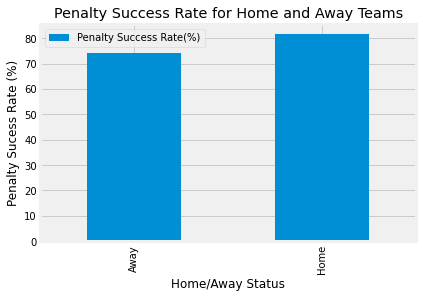

In [12]:
bar_chart = count_sums_df.plot.bar(x='Team taking pen_Home', 
                                   y="Scored_YES_%", 
                                   title = "Penalty Success Rate for Home and Away Teams")
bar_chart.set_xlabel("Home/Away Status")
bar_chart.set_ylabel("Penalty Sucess Rate (%)")
bar_chart.legend(['Penalty Success Rate(%)'])
count_sums_df['Team taking pen_Home'].value_counts().plot(kind='bar')
plt.xticks([0,1],['Away', 'Home'])
plt.show()

For the first graph: the success rate for penalties is higher for Home teams compared to Away teams which is probably because of the home crowd support.

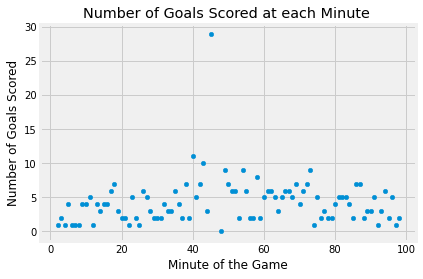

In [13]:
# Second Graph - Scatter Plot

data3 = data[["Minute", "Scored_YES"]]
count_sums_sp = data3.groupby(['Minute']).sum()
count_sums_sp.reset_index(inplace=True)
scatter_plot = count_sums_sp.plot.scatter(y = "Scored_YES", x = "Minute", title = "Number of Goals Scored at each Minute ")
scatter_plot.set_xlabel("Minute of the Game")
scatter_plot.set_ylabel("Number of Goals Scored")
plt.show()

For the second graph:  It is interesting to note that there are many more penalties scored around the 45 minute mark, which is probably because that includes all the penalties in the extra time as well.  Moreover, there are no penalties at the 0 minute mark because the game has not properly started. Apart from that, the penalties scored are within the 0 - 10 goals range per minute.

### Second Question
In second question, we create a bar chart of striker vs non-striker in x-axis and their success rate in y-axis.

<AxesSubplot:xlabel='Striker'>

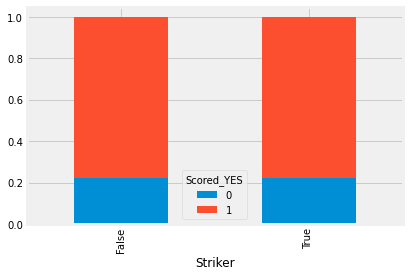

In [14]:
data_q2 = data
data_q2['Striker'] = data_q2['PT position']=='ST'
q2 = data_q2[['Striker','Scored_YES']]
t2=pd.crosstab(q2['Striker'],q2['Scored_YES']).apply(lambda r: r/r.sum(), axis=1)
t2.plot.bar(stacked=True)

In [15]:
t2

Scored_YES,0,1
Striker,,
False,0.220588,0.779412
True,0.222656,0.777344


As we can see, the average penalty success rate of strikers is 77.9% while that of non-strikers is 78.4%. There does not seem to be a significant difference.

### Third Question
In third question, we make two graphs. 
1. A scatter plot of success rate against payroll.
2. A scatter plot of success rate against capacity. 

In [16]:
# Getting the necessary information
# SPRC stands for Success Rate, Payroll, Capacity
penalty_SRPC = data[['PT team', 'Scored_YES']].groupby(by=['PT team']).sum()\
                                              .sort_values(['Scored_YES'], ascending=False)
num_penalty = pd.DataFrame({"Num_taken": data[['PT team']].value_counts()}).reset_index()
penalty_SRPC = penalty_SRPC.join(num_penalty.set_index('PT team'), on='PT team')\
                           .join(payroll.set_index('Club'), on='PT team')\
                           .join(capacity.set_index('HomeTeams'), on='PT team')
# removing less than 2 penalties because they skew the success rate too much
penalty_SRPC = penalty_SRPC[penalty_SRPC['Num_taken'] > 2]
penalty_SRPC.head()

,Scored_YES,Num_taken,Payroll_EUR,Stadium cap
PT team,,,,
Lazio,15,18,6.411000e+09,70634.0
Juventus,14,15,2.527600e+10,41507.0
Roma,12,14,1.158800e+10,70634.0
Napoli,11,12,1.000600e+10,60240.0
Atalanta,11,15,3.682000e+09,24726.0


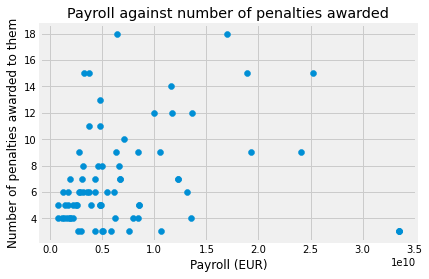

In [17]:
# number of penalties awarded to team against payroll
plt.scatter(penalty_SRPC['Payroll_EUR'], penalty_SRPC['Num_taken'])
plt.xlabel('Payroll (EUR)')
plt.ylabel('Number of penalties awarded to them')
plt.title('Payroll against number of penalties awarded')
plt.show()

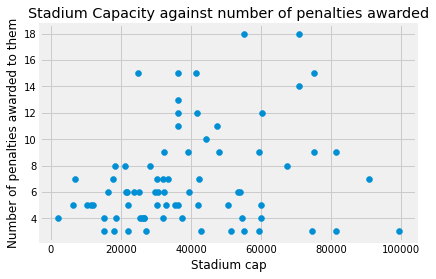

In [18]:
# number of penalties awarded to team against stadium capacity
plt.scatter(penalty_SRPC['Stadium cap'], penalty_SRPC['Num_taken'])
plt.xlabel('Stadium cap')
plt.ylabel('Number of penalties awarded to them')
plt.title('Stadium Capacity against number of penalties awarded')
plt.show()

From both graphs, we see that there might be positive correlation between:
1. number of penalties awarded and payroll
2. number of penalties awarded and stadium capacity

## Timeline

| Duration | Work |
|:-----------------------------------------|:-----------------|
| 23rd March – 26th March | Prepare the data |
|27th March – 30th March | Each of us takes one question and performs data processing and analysis then consults with the others |
|31st March – 2nd April | Revision using feedback received |
|3rd April | Meet and discuss our work |
|4th April – 5th April | Put everything into a presentation |
|6th April | Presentation dry run and submission| 

## Teamwork

| Work | Jerri | Edward | Rana |
|:-----------------|:-----------------|:-----------------|:-----------------|
| Before Analysis | Prepare data (join) | Presentation | Presentation |
| Question | 3 | 2 | 1 |